# Chapter 19 - Facebook's Prophet

## Listing 19-1. Preparing the dependent variable

In [ ]:
import pandas as pd
y = pd.read_csv('https://drive.google.com/uc?id=17bLj5NmMBrUEUHrdFPaGGIDjPvIgbnZK', compression='zip')
y = y.pivot(index='visit_date', columns='air_store_id')['visitors']
y = y.fillna(0)
y = pd.DataFrame(y.sum(axis=1))


In [ ]:
y.head()

,0
visit_date,
2016-01-01,1033.0
2016-01-02,1764.0
2016-01-03,2368.0
2016-01-04,3326.0
2016-01-05,3927.0


## Listing 19-2. Preparing the modeling data frame

In [ ]:
y = y.reset_index(drop=False)
y.columns = ['ds', 'y']


## Listing 19-3. Creating a train-test split

In [ ]:
train = y.iloc[:450,:]
test = y.iloc[450:,:]


## Listing 19-4. Creating a basic Prophet model

In [ ]:
from fbprophet import Prophet
m = Prophet()
m.fit(train)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Listing 19-5. Creating a basic Prophet model

In [ ]:
future = m.make_future_dataframe(periods=len(test))
forecast = m.predict(future)


## Listing 19-6. Creating a basic Prophet model

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(list(test['y']), list(forecast.loc[450:,'yhat'] )))


0.8084861773228342


## Listing 19-7. Plotting the fit of the model

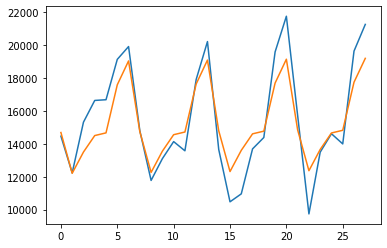

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list(test['y']))
plt.plot(list(forecast.loc[450:,'yhat'] ))
plt.rcParams['figure.figsize'] = [20, 10]
plt.show()


## Listing 19-8. Creating a Prophet forecast plot

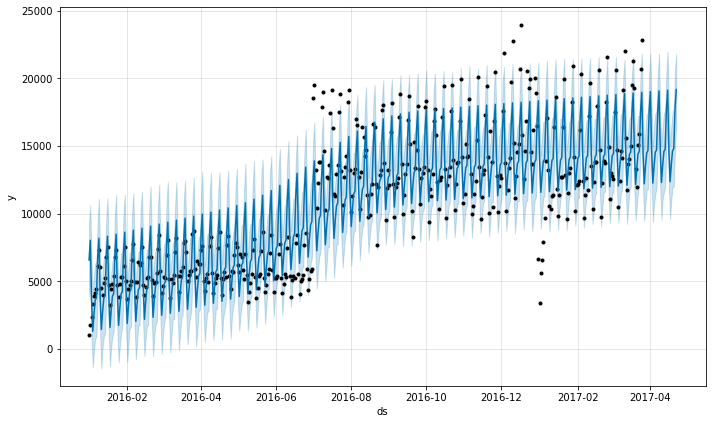

In [ ]:
from fbprophet.plot import plot

#plot(m, forecast, figsize=(20, 12))

fig1 = m.plot(forecast)

plt.show()


## Listing 19-9. Creating a Prophet decomposition plot

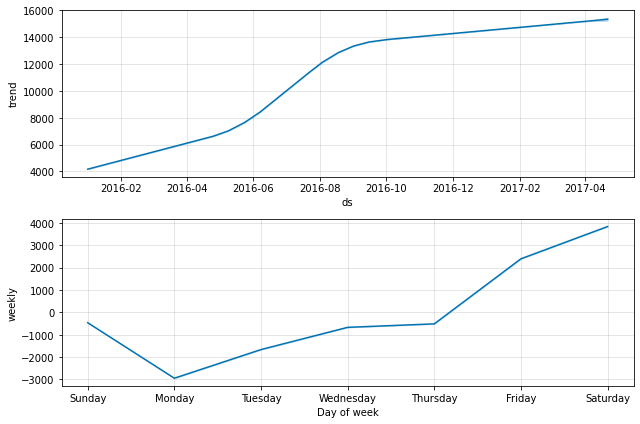

In [ ]:
fig2 = m.plot_components(forecast)
plt.show()


## Listing 19-10. Add montly seasonality to the plot

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.7877769983422085


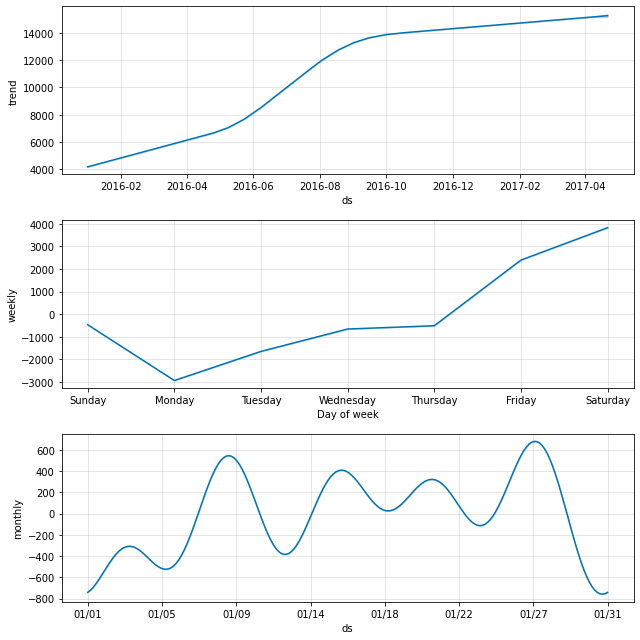

In [ ]:
m2 = Prophet()
m2.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m2.fit(train)

future2 = m2.make_future_dataframe(periods=len(test))
forecast2 = m2.predict(future)
print(r2_score(list(test['y']), list(forecast2.loc[450:,'yhat'] )))

fig2 = m2.plot_components(forecast2)
plt.show()


## Listing 19-11. Prepare holidays data

In [ ]:
holidays = pd.read_csv('https://drive.google.com/uc?id=1jw5V4noLicmWk-xu8qFzFCPxV5LaQRVB', compression='zip')
holidays = holidays[holidays['holiday_flg'] == 1]
holidays = holidays[['calendar_date', 'holiday_flg']]
holidays = holidays.drop(['holiday_flg'], axis=1)
holidays['holiday'] = 'holiday'
holidays.columns = ['ds', 'holiday']


## Listing 19-12. Add holidays to the model

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.8062679163389088


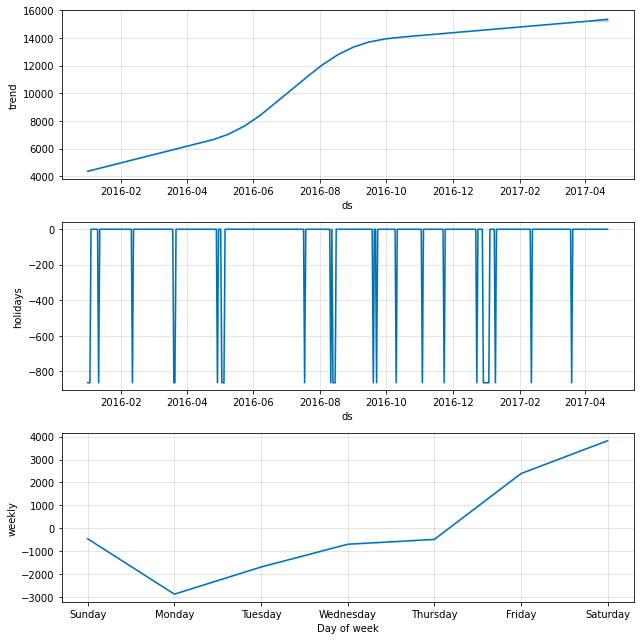

In [ ]:
m3 = Prophet(holidays=holidays)
m3.fit(train)
future3 = m3.make_future_dataframe(periods=len(test))
forecast3 = m3.predict(future)

print(r2_score(list(test['y']), list(forecast3.loc[450:,'yhat'] )))

fig2 = m3.plot_components(forecast3)
plt.show()


## Listing 19-13. Add reservations to the model

In [ ]:
X_reservations = pd.read_csv('https://drive.google.com/uc?id=1XG_wEiSnXhoNi-_NBuHpxJSjRXaZeH4n', compression='zip')
X_reservations['visit_date'] = pd.to_datetime(X_reservations['visit_datetime']).dt.date
X_reservations = pd.DataFrame(X_reservations.groupby('visit_date')['reserve_visitors'].sum())
X_reservations = X_reservations.reset_index(drop = False)
train4 = train.copy()
train4['ds'] = pd.to_datetime(train4['ds']).dt.date
train4 = train4.merge(X_reservations, left_on = 'ds', right_on = 'visit_date', how = 'left')[['ds', 'y', 'reserve_visitors']].fillna(0)


## Listing 19-14. Add reservations to the model

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.848896648390201


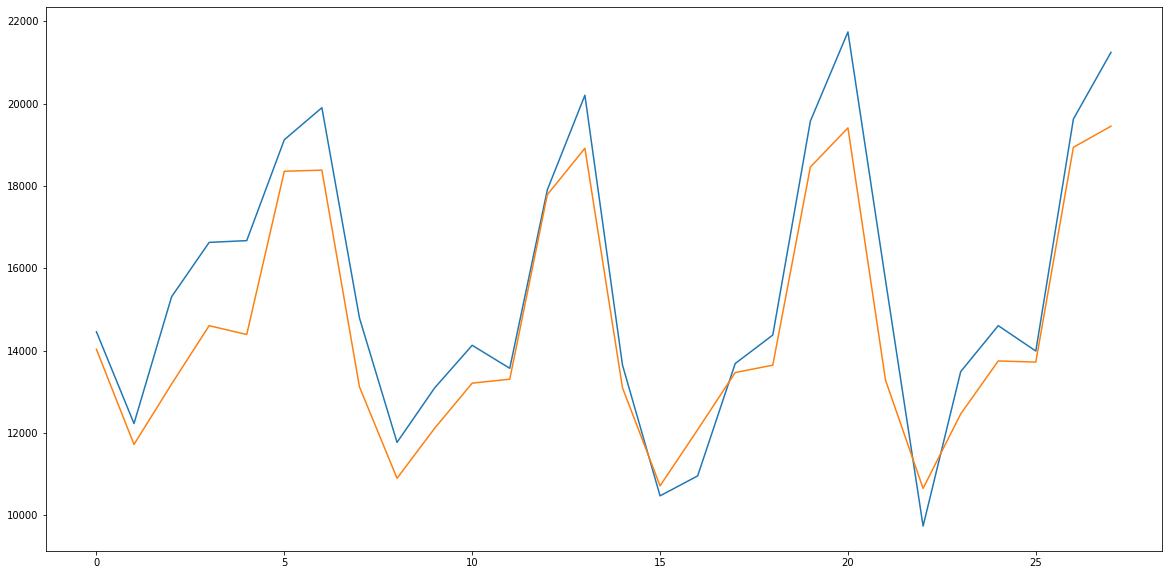

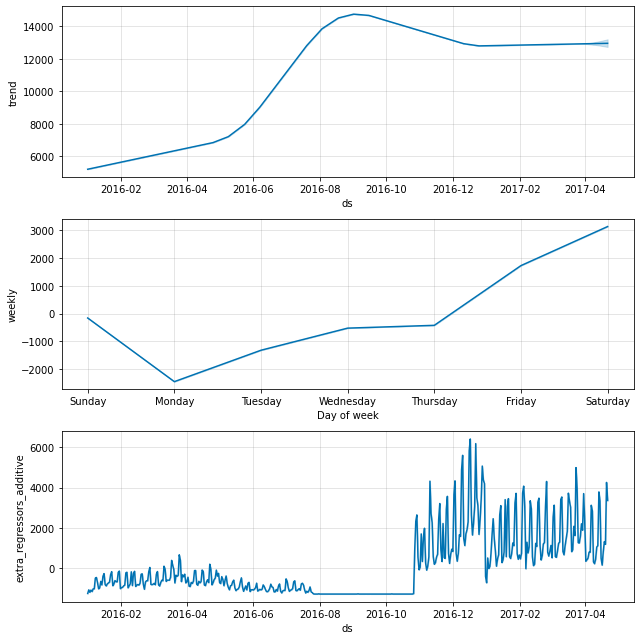

In [ ]:
m4 = Prophet()
m4.add_regressor('reserve_visitors')
m4.fit(train4)
future4 = m4.make_future_dataframe(periods=len(test))
future4['ds'] = pd.to_datetime(future4['ds']).dt.date

future4 = future4.merge(X_reservations, left_on = 'ds', right_on = 'visit_date', how = 'left')[['ds', 'reserve_visitors']].fillna(0)

forecast4 = m4.predict(future4)

print(r2_score(list(test['y']), list(forecast4.loc[450:,'yhat'] )))

plt.plot(list(test['y']))
plt.plot(list(forecast4.loc[450:,'yhat'] ))

fig2 = m4.plot_components(forecast4)
plt.show()


## Listing 19-15. Grid Searching the Prophet

In [ ]:
def model_test(holidays, weekly_seasonality,yearly_seasonality, add_monthly, add_reserve, changepoint_prior_scale, holidays_prior_scale, month_fourier):
    
    m4 = Prophet(
          yearly_seasonality=yearly_seasonality, 
          weekly_seasonality=weekly_seasonality, 
          holidays=holidays, 
          changepoint_prior_scale=changepoint_prior_scale, 
          holidays_prior_scale=holidays_prior_scale)
    
    if add_monthly:    
        m4.add_seasonality(
        name='monthly', 
        period=30.5, 
        fourier_order=month_fourier)
    
    if add_reserve:
        m4.add_regressor('reserve_visitors')

    m4.fit(train4)

    future4 = m4.make_future_dataframe(periods=len(test))

    future4['ds'] = pd.to_datetime(future4['ds']).dt.date
    
    if add_reserve:
        future4 = future4.merge(
            X_reservations, 
            left_on = 'ds', 
            right_on = 'visit_date', 
            how = 'left')
        future4 = future4[['ds', 'reserve_visitors']]
        future4 = future4.fillna(0)

    forecast4 = m4.predict(future4)

    return r2_score(
              list(test['y']),
              list(forecast4.loc[450:,'yhat'] )) 
# Setting the grid
holidays_opt = [holidays, None]
weekly_seas = [ 5, 10, 30, 50]
yearly_seas = [ 5, 10, 30, 50]
add_monthly = [True, False]
add_reserve = [True, False]
changepoint_prior_scale = [0.1, 0.3, 0.5]
holidays_prior_scale = [0.1, 0.3, 0.5]
month_fourier = [5, 10, 30, 50]

# Looping through the grid
grid_results = []
for h in holidays_opt:
  for w in weekly_seas:
    for ys in yearly_seas:
      for m in add_monthly:
        for r in add_reserve:
           for c in changepoint_prior_scale:
             for hp in holidays_prior_scale:
               for mf in month_fourier:
                  r2=model_test(h,w,ys,m,r,c,hp,mf)
                  print([w,ys,m,r,c,hp,mf,r2])
                  grid_results.append([h,w,ys,m,r,c,hp,mf,r2])

# adding it all to a dataframe and extract the best model
benchmark = pd.DataFrame(grid_results)
benchmark = benchmark.sort_values(8, ascending=False)

h, w,ys, m, r, c,hp,mf,r2 = list(benchmark.iloc[0,:])

# Fit the Prophet with those best hyperparameters
m4 = Prophet(
          yearly_seasonality=ys, 
          weekly_seasonality=w, 
          holidays=h, 
          changepoint_prior_scale=c, 
          holidays_prior_scale=hp)
    
if m:    
    m4.add_seasonality(
        name='monthly', 
        period=30.5, 
        fourier_order=mf)

if r:
    m4.add_regressor('reserve_visitors')

m4.fit(train4)

future4 = m4.make_future_dataframe(periods=len(test))

future4['ds'] = pd.to_datetime(future4['ds']).dt.date

if r:
    future4 = future4.merge(
                X_reservations, 
                left_on = 'ds', 
                right_on = 'visit_date', 
                how = 'left')
    future4 = future4[['ds', 'reserve_visitors']]
    future4 = future4.fillna(0)

forecast4 = m4.predict(future4)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.1, 0.1, 5, 0.9053947075596465]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.1, 0.1, 10, 0.9055661484144439]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.1, 0.1, 30, 0.9182952765059765]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.1, 0.1, 50, 0.917323687475446]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.1, 0.3, 5, 0.9055279183091324]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.1, 0.3, 10, 0.904878243548976]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.1, 0.3, 30, 0.9182451367366623]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.1, 0.3, 50, 0.916473900857433]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.1, 0.5, 5, 0.9030211597252639]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.1, 0.5, 10, 0.9058278326585444]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.1, 0.5, 30, 0.9179106624595331]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.1, 0.5, 50, 0.9175810637113739]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.3, 0.1, 5, 0.8296532719303888]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.3, 0.1, 10, 0.8440179720380685]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.3, 0.1, 30, 0.8937364536351967]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.3, 0.1, 50, 0.9034687753672481]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.3, 0.3, 5, 0.8455668820797121]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.3, 0.3, 10, 0.8211163269860708]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.3, 0.3, 30, 0.899782057826443]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.3, 0.3, 50, 0.8962530137062308]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.3, 0.5, 5, 0.8445380382975561]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.3, 0.5, 10, 0.8493397179912656]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.3, 0.5, 30, 0.9019594329067373]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.3, 0.5, 50, 0.9021214820993132]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.5, 0.1, 5, 0.7966930304611397]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.5, 0.1, 10, 0.8003301425418985]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.5, 0.1, 30, 0.8825193849775679]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.5, 0.1, 50, 0.881055271316495]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.5, 0.3, 5, 0.7850952733782434]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.5, 0.3, 10, 0.7950434760816675]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.5, 0.3, 30, 0.8823046970193945]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.5, 0.3, 50, 0.8825626972870986]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.5, 0.5, 5, 0.791648085349131]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.5, 0.5, 10, 0.8063189986313849]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.5, 0.5, 30, 0.8788807963470454]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, True, 0.5, 0.5, 50, 0.8805115870481082]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.1, 0.1, 5, 0.7806662585442926]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.1, 0.1, 10, 0.7783444515400306]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.1, 0.1, 30, 0.7610354457664111]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.1, 0.1, 50, 0.7607785575155463]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.1, 0.3, 5, 0.7807576244777195]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.1, 0.3, 10, 0.7781242033080653]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.1, 0.3, 30, 0.7605120859705907]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.1, 0.3, 50, 0.7607104360364855]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.1, 0.5, 5, 0.7819817318321938]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.1, 0.5, 10, 0.778538622457769]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.1, 0.5, 30, 0.7607864442654149]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.1, 0.5, 50, 0.7608200446373051]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.3, 0.1, 5, 0.6610598868936804]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.3, 0.1, 10, 0.6642428319527522]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.3, 0.1, 30, 0.7111325910517334]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.3, 0.1, 50, 0.7104057893554623]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.3, 0.3, 5, 0.6541908049841609]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.3, 0.3, 10, 0.6463859994178407]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.3, 0.3, 30, 0.7015225393645205]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.3, 0.3, 50, 0.7091362250339708]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.3, 0.5, 5, 0.6722025717878377]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.3, 0.5, 10, 0.6741808428175506]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.3, 0.5, 30, 0.70216001189722]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.3, 0.5, 50, 0.7092104961683616]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.5, 0.1, 5, 0.5661382912875215]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.5, 0.1, 10, 0.522019364463203]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.5, 0.1, 30, 0.6406218192262063]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.5, 0.1, 50, 0.6456451083928478]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.5, 0.3, 5, 0.531937599783628]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.5, 0.3, 10, 0.5487323991689729]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.5, 0.3, 30, 0.6365760798977703]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.5, 0.3, 50, 0.6170577393843091]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.5, 0.5, 5, 0.43603078895133396]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.5, 0.5, 10, 0.5018149458420414]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.5, 0.5, 30, 0.6487203010187821]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, True, False, 0.5, 0.5, 50, 0.6585442827992289]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.1, 0.1, 5, 0.9124263896286603]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.1, 0.1, 10, 0.9124263896286603]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.1, 0.1, 30, 0.9124263896286603]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.1, 0.1, 50, 0.9124263896286603]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.1, 0.3, 5, 0.9113272553308157]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.1, 0.3, 10, 0.9113272553308157]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.1, 0.3, 30, 0.9113272553308157]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.1, 0.3, 50, 0.9113272553308157]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.1, 0.5, 5, 0.9101988811309918]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.1, 0.5, 10, 0.9101988811309918]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.1, 0.5, 30, 0.9101988811309918]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.1, 0.5, 50, 0.9101988811309918]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.3, 0.1, 5, 0.8505213621688745]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.3, 0.1, 10, 0.8505213621688745]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.3, 0.1, 30, 0.8505213621688745]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.3, 0.1, 50, 0.8505213621688745]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.3, 0.3, 5, 0.8485732166110578]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.3, 0.3, 10, 0.8485732166110578]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.3, 0.3, 30, 0.8485732166110578]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.3, 0.3, 50, 0.8485732166110578]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.3, 0.5, 5, 0.8408263176849637]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.3, 0.5, 10, 0.8408263176849637]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.3, 0.5, 30, 0.8408263176849637]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.3, 0.5, 50, 0.8408263176849637]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.5, 0.1, 5, 0.7876519491905025]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.5, 0.1, 10, 0.7876519491905025]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.5, 0.1, 30, 0.7876519491905025]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.5, 0.1, 50, 0.7876519491905025]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.5, 0.3, 5, 0.7863205741198431]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.5, 0.3, 10, 0.7863205741198431]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.5, 0.3, 30, 0.7863205741198431]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.5, 0.3, 50, 0.7863205741198431]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.5, 0.5, 5, 0.7930132130401278]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.5, 0.5, 10, 0.7930132130401278]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.5, 0.5, 30, 0.7930132130401278]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, True, 0.5, 0.5, 50, 0.7930132130401278]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.1, 0.1, 5, 0.7995645928266706]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.1, 0.1, 10, 0.7995645928266706]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.1, 0.1, 30, 0.7995645928266706]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.1, 0.1, 50, 0.7995645928266706]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.1, 0.3, 5, 0.7976789035601728]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.1, 0.3, 10, 0.7976789035601728]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.1, 0.3, 30, 0.7976789035601728]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.1, 0.3, 50, 0.7976789035601728]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.1, 0.5, 5, 0.7995565899208652]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.1, 0.5, 10, 0.7995565899208652]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.1, 0.5, 30, 0.7995565899208652]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.1, 0.5, 50, 0.7995565899208652]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.3, 0.1, 5, 0.6944569004932608]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.3, 0.1, 10, 0.6944569004932608]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.3, 0.1, 30, 0.6944569004932608]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.3, 0.1, 50, 0.6944569004932608]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.3, 0.3, 5, 0.6832873229690429]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.3, 0.3, 10, 0.6832873229690429]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.3, 0.3, 30, 0.6832873229690429]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.3, 0.3, 50, 0.6832873229690429]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.3, 0.5, 5, 0.6914714097161087]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.3, 0.5, 10, 0.6914714097161087]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.3, 0.5, 30, 0.6914714097161087]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.3, 0.5, 50, 0.6914714097161087]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.5, 0.1, 5, 0.5497621751092345]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.5, 0.1, 10, 0.5497621751092345]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.5, 0.1, 30, 0.5497621751092345]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.5, 0.1, 50, 0.5497621751092345]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.5, 0.3, 5, 0.49409970199125564]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.5, 0.3, 10, 0.49409970199125564]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.5, 0.3, 30, 0.49409970199125564]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.5, 0.3, 50, 0.49409970199125564]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.5, 0.5, 5, 0.5309310956084511]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.5, 0.5, 10, 0.5309310956084511]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.5, 0.5, 30, 0.5309310956084511]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 5, False, False, 0.5, 0.5, 50, 0.5309310956084511]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.1, 0.1, 5, 0.9213933747069114]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.1, 0.1, 10, 0.9235121697715433]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.1, 0.1, 30, 0.9036415313507004]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.1, 0.1, 50, 0.9016443240395915]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.1, 0.3, 5, 0.9212606029229341]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.1, 0.3, 10, 0.9237142534697054]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.1, 0.3, 30, 0.9034964441385381]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.1, 0.3, 50, 0.901227036640159]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.1, 0.5, 5, 0.9207952031823589]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.1, 0.5, 10, 0.9232017111578346]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.1, 0.5, 30, 0.9032846015148188]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.1, 0.5, 50, 0.9012161321044798]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.3, 0.1, 5, 0.9019301884296334]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.3, 0.1, 10, 0.905091132867694]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.3, 0.1, 30, 0.8828453726807248]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.3, 0.1, 50, 0.8825775672747771]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.3, 0.3, 5, 0.9037324323489766]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.3, 0.3, 10, 0.9049044115051196]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.3, 0.3, 30, 0.8856172656616376]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.3, 0.3, 50, 0.8865618861081269]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.3, 0.5, 5, 0.9025341931795311]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.3, 0.5, 10, 0.9038943347731712]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.3, 0.5, 30, 0.882322022422441]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.3, 0.5, 50, 0.8815136802197535]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.5, 0.1, 5, 0.8878940145347116]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.5, 0.1, 10, 0.8912439285257236]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.5, 0.1, 30, 0.8708700283672071]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.5, 0.1, 50, 0.8735611647676579]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.5, 0.3, 5, 0.8879033187982891]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.5, 0.3, 10, 0.8914395953145859]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.5, 0.3, 30, 0.8689961187678423]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.5, 0.3, 50, 0.8698028188222905]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.5, 0.5, 5, 0.8881529893814897]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.5, 0.5, 10, 0.8907679658965261]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.5, 0.5, 30, 0.8725959999820408]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, True, 0.5, 0.5, 50, 0.8750747391336668]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.1, 0.1, 5, 0.8043429586102187]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.1, 0.1, 10, 0.8008778848370091]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.1, 0.1, 30, 0.764038647091335]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.1, 0.1, 50, 0.7679549480667898]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.1, 0.3, 5, 0.8042595326993477]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.1, 0.3, 10, 0.8009305281575015]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.1, 0.3, 30, 0.7666776521464337]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.1, 0.3, 50, 0.7689663128097863]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.1, 0.5, 5, 0.8042973652511143]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.1, 0.5, 10, 0.7999135571530521]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.1, 0.5, 30, 0.7688248428294002]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.1, 0.5, 50, 0.7641688278281017]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.3, 0.1, 5, 0.7469612698609374]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.3, 0.1, 10, 0.7454763771821211]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.3, 0.1, 30, 0.6880084156111412]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.3, 0.1, 50, 0.6975103489899306]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.3, 0.3, 5, 0.7371497985180819]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.3, 0.3, 10, 0.7455353227610333]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.3, 0.3, 30, 0.701164701217396]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.3, 0.3, 50, 0.7001317390273278]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.3, 0.5, 5, 0.7430267463787588]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.3, 0.5, 10, 0.7448290861907013]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.3, 0.5, 30, 0.6931774627513428]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.3, 0.5, 50, 0.7082954163595201]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.5, 0.1, 5, 0.7105803210078918]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.5, 0.1, 10, 0.7112473710286826]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.5, 0.1, 30, 0.6535122994491565]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.5, 0.1, 50, 0.6570833639348574]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.5, 0.3, 5, 0.7067572524800616]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.5, 0.3, 10, 0.7083293070813288]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.5, 0.3, 30, 0.6514852243700053]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.5, 0.3, 50, 0.6574049124438904]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.5, 0.5, 5, 0.713252855821324]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.5, 0.5, 10, 0.7143568160565945]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.5, 0.5, 30, 0.6511164303410424]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, True, False, 0.5, 0.5, 50, 0.6435943973447789]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.1, 0.1, 5, 0.9281456950034379]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.1, 0.1, 10, 0.9281456950034379]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.1, 0.1, 30, 0.9281456950034379]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.1, 0.1, 50, 0.9281456950034379]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.1, 0.3, 5, 0.9280153498763002]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.1, 0.3, 10, 0.9280153498763002]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.1, 0.3, 30, 0.9280153498763002]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.1, 0.3, 50, 0.9280153498763002]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.1, 0.5, 5, 0.9274511654117796]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.1, 0.5, 10, 0.9274511654117796]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.1, 0.5, 30, 0.9274511654117796]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.1, 0.5, 50, 0.9274511654117796]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.3, 0.1, 5, 0.908480366073279]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.3, 0.1, 10, 0.908480366073279]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.3, 0.1, 30, 0.908480366073279]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.3, 0.1, 50, 0.908480366073279]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.3, 0.3, 5, 0.9094131720143499]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.3, 0.3, 10, 0.9094131720143499]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.3, 0.3, 30, 0.9094131720143499]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.3, 0.3, 50, 0.9094131720143499]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.3, 0.5, 5, 0.9079266440939553]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.3, 0.5, 10, 0.9079266440939553]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.3, 0.5, 30, 0.9079266440939553]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.3, 0.5, 50, 0.9079266440939553]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.5, 0.1, 5, 0.8979988355009624]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.5, 0.1, 10, 0.8979988355009624]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.5, 0.1, 30, 0.8979988355009624]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.5, 0.1, 50, 0.8979988355009624]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.5, 0.3, 5, 0.895392663297837]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.5, 0.3, 10, 0.895392663297837]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.5, 0.3, 30, 0.895392663297837]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.5, 0.3, 50, 0.895392663297837]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.5, 0.5, 5, 0.8968474476274636]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.5, 0.5, 10, 0.8968474476274636]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.5, 0.5, 30, 0.8968474476274636]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, True, 0.5, 0.5, 50, 0.8968474476274636]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.1, 0.1, 5, 0.8240024449089923]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.1, 0.1, 10, 0.8240024449089923]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.1, 0.1, 30, 0.8240024449089923]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.1, 0.1, 50, 0.8240024449089923]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.1, 0.3, 5, 0.8245671240511337]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.1, 0.3, 10, 0.8245671240511337]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.1, 0.3, 30, 0.8245671240511337]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.1, 0.3, 50, 0.8245671240511337]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.1, 0.5, 5, 0.8245253061516639]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.1, 0.5, 10, 0.8245253061516639]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.1, 0.5, 30, 0.8245253061516639]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.1, 0.5, 50, 0.8245253061516639]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.3, 0.1, 5, 0.7651540200064113]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.3, 0.1, 10, 0.7651540200064113]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.3, 0.1, 30, 0.7651540200064113]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.3, 0.1, 50, 0.7651540200064113]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.3, 0.3, 5, 0.7620951701364145]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.3, 0.3, 10, 0.7620951701364145]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.3, 0.3, 30, 0.7620951701364145]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.3, 0.3, 50, 0.7620951701364145]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.3, 0.5, 5, 0.7632671098778242]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.3, 0.5, 10, 0.7632671098778242]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.3, 0.5, 30, 0.7632671098778242]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.3, 0.5, 50, 0.7632671098778242]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.5, 0.1, 5, 0.726925820322549]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.5, 0.1, 10, 0.726925820322549]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.5, 0.1, 30, 0.726925820322549]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.5, 0.1, 50, 0.726925820322549]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.5, 0.3, 5, 0.7298777194576787]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.5, 0.3, 10, 0.7298777194576787]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.5, 0.3, 30, 0.7298777194576787]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.5, 0.3, 50, 0.7298777194576787]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.5, 0.5, 5, 0.7353083183915123]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.5, 0.5, 10, 0.7353083183915123]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.5, 0.5, 30, 0.7353083183915123]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 10, False, False, 0.5, 0.5, 50, 0.7353083183915123]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.1, 0.1, 5, 0.9083105024335123]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.1, 0.1, 10, 0.9104167246808652]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.1, 0.1, 30, 0.8892762177575376]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.1, 0.1, 50, 0.8961328335969783]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.1, 0.3, 5, 0.9106212503516785]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.1, 0.3, 10, 0.9107547590788987]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.1, 0.3, 30, 0.8855297180680015]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.1, 0.3, 50, 0.8908780780947173]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.1, 0.5, 5, 0.906806116695893]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.1, 0.5, 10, 0.9128852147707486]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.1, 0.5, 30, 0.8900652541211757]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.1, 0.5, 50, 0.888274161941943]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.3, 0.1, 5, 0.8658419162592045]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.3, 0.1, 10, 0.8719241908478115]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.3, 0.1, 30, 0.8489474361010847]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.3, 0.1, 50, 0.8490338467971414]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.3, 0.3, 5, 0.8666314882017716]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.3, 0.3, 10, 0.8663402759654653]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.3, 0.3, 30, 0.851519703778414]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.3, 0.3, 50, 0.8479933467366362]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.3, 0.5, 5, 0.8675792894312577]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.3, 0.5, 10, 0.8669474236353997]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.3, 0.5, 30, 0.8521407984412219]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.3, 0.5, 50, 0.8546535900515034]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.5, 0.1, 5, 0.8513873202940868]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.5, 0.1, 10, 0.8539831621929932]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.5, 0.1, 30, 0.8406828891870675]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.5, 0.1, 50, 0.836428762195397]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.5, 0.3, 5, 0.8534995707389963]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.5, 0.3, 10, 0.8560903116432388]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.5, 0.3, 30, 0.839131016038618]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.5, 0.3, 50, 0.8395552430955755]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.5, 0.5, 5, 0.856051926499246]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.5, 0.5, 10, 0.8556375858898954]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.5, 0.5, 30, 0.8402227089804221]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, True, 0.5, 0.5, 50, 0.8389471053758204]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.1, 0.1, 5, 0.7819732225267756]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.1, 0.1, 10, 0.776591460417356]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.1, 0.1, 30, 0.7385658227508193]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.1, 0.1, 50, 0.7303267675259664]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.1, 0.3, 5, 0.7814087936280132]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.1, 0.3, 10, 0.7801817304929338]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.1, 0.3, 30, 0.7284422927284051]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.1, 0.3, 50, 0.7396880932409595]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.1, 0.5, 5, 0.7827438653093397]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.1, 0.5, 10, 0.7838130115110133]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.1, 0.5, 30, 0.7384538338082396]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.1, 0.5, 50, 0.7248900032064867]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.3, 0.1, 5, 0.7001246787660504]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.3, 0.1, 10, 0.6878647028510636]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.3, 0.1, 30, 0.6367026338725273]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.3, 0.1, 50, 0.6423320545890552]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.3, 0.3, 5, 0.6905839901238303]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.3, 0.3, 10, 0.6947260356304106]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.3, 0.3, 30, 0.6375907849648547]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.3, 0.3, 50, 0.6498844112505565]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.3, 0.5, 5, 0.6943278206405974]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.3, 0.5, 10, 0.6886019898495828]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.3, 0.5, 30, 0.6348076961369963]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.3, 0.5, 50, 0.6388587987828953]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.5, 0.1, 5, 0.6668935592799282]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.5, 0.1, 10, 0.6724525668368033]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.5, 0.1, 30, 0.6145993450779026]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.5, 0.1, 50, 0.614258791392226]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.5, 0.3, 5, 0.6646192881454862]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.5, 0.3, 10, 0.6635426705416032]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.5, 0.3, 30, 0.615638107477393]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.5, 0.3, 50, 0.6158320651852376]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.5, 0.5, 5, 0.668565907983717]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.5, 0.5, 10, 0.6645712727314075]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.5, 0.5, 30, 0.6144418536188323]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, True, False, 0.5, 0.5, 50, 0.6148476286370792]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.1, 0.1, 5, 0.9116106460209317]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.1, 0.1, 10, 0.9116106460209317]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.1, 0.1, 30, 0.9116106460209317]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.1, 0.1, 50, 0.9116106460209317]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.1, 0.3, 5, 0.9093085898731388]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.1, 0.3, 10, 0.9093085898731388]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.1, 0.3, 30, 0.9093085898731388]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.1, 0.3, 50, 0.9093085898731388]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.1, 0.5, 5, 0.910897677864143]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.1, 0.5, 10, 0.910897677864143]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.1, 0.5, 30, 0.910897677864143]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.1, 0.5, 50, 0.910897677864143]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.3, 0.1, 5, 0.8639614523863874]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.3, 0.1, 10, 0.8639614523863874]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.3, 0.1, 30, 0.8639614523863874]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.3, 0.1, 50, 0.8639614523863874]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.3, 0.3, 5, 0.867883944854727]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.3, 0.3, 10, 0.867883944854727]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.3, 0.3, 30, 0.867883944854727]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.3, 0.3, 50, 0.867883944854727]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.3, 0.5, 5, 0.8622782594212757]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.3, 0.5, 10, 0.8622782594212757]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.3, 0.5, 30, 0.8622782594212757]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.3, 0.5, 50, 0.8622782594212757]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.5, 0.1, 5, 0.8503694719154934]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.5, 0.1, 10, 0.8503694719154934]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.5, 0.1, 30, 0.8503694719154934]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.5, 0.1, 50, 0.8503694719154934]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.5, 0.3, 5, 0.8545070586670752]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.5, 0.3, 10, 0.8545070586670752]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.5, 0.3, 30, 0.8545070586670752]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.5, 0.3, 50, 0.8545070586670752]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.5, 0.5, 5, 0.8524031864129266]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.5, 0.5, 10, 0.8524031864129266]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.5, 0.5, 30, 0.8524031864129266]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, True, 0.5, 0.5, 50, 0.8524031864129266]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.1, 0.1, 5, 0.793855722743602]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.1, 0.1, 10, 0.793855722743602]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.1, 0.1, 30, 0.793855722743602]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.1, 0.1, 50, 0.793855722743602]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.1, 0.3, 5, 0.7866114183208455]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.1, 0.3, 10, 0.7866114183208455]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.1, 0.3, 30, 0.7866114183208455]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.1, 0.3, 50, 0.7866114183208455]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.1, 0.5, 5, 0.7863635730046981]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.1, 0.5, 10, 0.7863635730046981]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.1, 0.5, 30, 0.7863635730046981]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.1, 0.5, 50, 0.7863635730046981]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.3, 0.1, 5, 0.679994375808708]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.3, 0.1, 10, 0.679994375808708]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.3, 0.1, 30, 0.679994375808708]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.3, 0.1, 50, 0.679994375808708]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.3, 0.3, 5, 0.6771844258649142]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.3, 0.3, 10, 0.6771844258649142]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.3, 0.3, 30, 0.6771844258649142]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.3, 0.3, 50, 0.6771844258649142]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.3, 0.5, 5, 0.6756411857548962]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.3, 0.5, 10, 0.6756411857548962]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.3, 0.5, 30, 0.6756411857548962]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.3, 0.5, 50, 0.6756411857548962]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.5, 0.1, 5, 0.6569638779960429]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.5, 0.1, 10, 0.6569638779960429]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.5, 0.1, 30, 0.6569638779960429]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.5, 0.1, 50, 0.6569638779960429]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.5, 0.3, 5, 0.6509637169669087]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.5, 0.3, 10, 0.6509637169669087]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.5, 0.3, 30, 0.6509637169669087]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.5, 0.3, 50, 0.6509637169669087]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.5, 0.5, 5, 0.6514528767750085]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.5, 0.5, 10, 0.6514528767750085]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.5, 0.5, 30, 0.6514528767750085]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 30, False, False, 0.5, 0.5, 50, 0.6514528767750085]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.1, 0.1, 5, 0.8589336592991077]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.1, 0.1, 10, 0.8581002844814748]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.1, 0.1, 30, 0.841416509549514]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.1, 0.1, 50, 0.8491415963523169]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.1, 0.3, 5, 0.8548209845550505]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.1, 0.3, 10, 0.8508230583834246]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.1, 0.3, 30, 0.8405468398478682]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.1, 0.3, 50, 0.8455226496962628]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.1, 0.5, 5, 0.8565119314370763]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.1, 0.5, 10, 0.8504559415827659]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.1, 0.5, 30, 0.8449732831745954]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.1, 0.5, 50, 0.843683021305222]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.3, 0.1, 5, 0.8034860441495446]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.3, 0.1, 10, 0.8056833415084957]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.3, 0.1, 30, 0.7889478113157479]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.3, 0.1, 50, 0.7840869539258395]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.3, 0.3, 5, 0.8045332929714226]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.3, 0.3, 10, 0.8081315297588003]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.3, 0.3, 30, 0.786960626286044]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.3, 0.3, 50, 0.7871733732482512]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.3, 0.5, 5, 0.8049944620707142]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.3, 0.5, 10, 0.8167965853846221]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.3, 0.5, 30, 0.7893331346623784]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.3, 0.5, 50, 0.7837777366264266]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.5, 0.1, 5, 0.7932429697870093]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.5, 0.1, 10, 0.7950624161661584]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.5, 0.1, 30, 0.7720950705487557]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.5, 0.1, 50, 0.7716176146215231]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.5, 0.3, 5, 0.7926294071155668]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.5, 0.3, 10, 0.793706007246357]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.5, 0.3, 30, 0.7750400768703911]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.5, 0.3, 50, 0.7735662644530164]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.5, 0.5, 5, 0.7919524340645288]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.5, 0.5, 10, 0.7952431567460263]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.5, 0.5, 30, 0.7703729181824]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, True, 0.5, 0.5, 50, 0.7699998935591252]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.1, 0.1, 5, 0.6594468012757211]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.1, 0.1, 10, 0.6555497551390735]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.1, 0.1, 30, 0.6476956656998094]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.1, 0.1, 50, 0.6629321805941075]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.1, 0.3, 5, 0.658930118191605]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.1, 0.3, 10, 0.6599643889772686]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.1, 0.3, 30, 0.646184901020305]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.1, 0.3, 50, 0.6338296883994147]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.1, 0.5, 5, 0.6632166776249729]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.1, 0.5, 10, 0.6538050365964428]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.1, 0.5, 30, 0.6608010526216265]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.1, 0.5, 50, 0.6574326626171715]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.3, 0.1, 5, 0.5551642132987891]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.3, 0.1, 10, 0.5528451465431967]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.3, 0.1, 30, 0.5128878236278979]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.3, 0.1, 50, 0.5163743138443182]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.3, 0.3, 5, 0.568806832555532]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.3, 0.3, 10, 0.5567545356181495]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.3, 0.3, 30, 0.507195298503871]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.3, 0.3, 50, 0.5135400411668273]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.3, 0.5, 5, 0.5624193651752933]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.3, 0.5, 10, 0.5578530950321878]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.3, 0.5, 30, 0.5110385357021511]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.3, 0.5, 50, 0.5168305411919081]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.5, 0.1, 5, 0.5299345423659614]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.5, 0.1, 10, 0.5328485658862196]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.5, 0.1, 30, 0.4720620195816805]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.5, 0.1, 50, 0.48151156135347495]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.5, 0.3, 5, 0.5334478409030223]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.5, 0.3, 10, 0.5399172797553975]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.5, 0.3, 30, 0.48036953754937717]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.5, 0.3, 50, 0.47922151755492715]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.5, 0.5, 5, 0.5333526343349804]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.5, 0.5, 10, 0.5305247110657028]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.5, 0.5, 30, 0.4834545101481813]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, True, False, 0.5, 0.5, 50, 0.48067390675290544]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.1, 0.1, 5, 0.8619350418171803]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.1, 0.1, 10, 0.8619350418171803]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.1, 0.1, 30, 0.8619350418171803]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.1, 0.1, 50, 0.8619350418171803]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.1, 0.3, 5, 0.8549348106982055]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.1, 0.3, 10, 0.8549348106982055]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.1, 0.3, 30, 0.8549348106982055]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.1, 0.3, 50, 0.8549348106982055]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.1, 0.5, 5, 0.8613929405693888]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.1, 0.5, 10, 0.8613929405693888]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.1, 0.5, 30, 0.8613929405693888]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.1, 0.5, 50, 0.8613929405693888]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.3, 0.1, 5, 0.803610674423097]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.3, 0.1, 10, 0.803610674423097]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.3, 0.1, 30, 0.803610674423097]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.3, 0.1, 50, 0.803610674423097]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.3, 0.3, 5, 0.7969214574777146]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.3, 0.3, 10, 0.7969214574777146]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.3, 0.3, 30, 0.7969214574777146]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.3, 0.3, 50, 0.7969214574777146]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.3, 0.5, 5, 0.7983521495328179]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.3, 0.5, 10, 0.7983521495328179]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.3, 0.5, 30, 0.7983521495328179]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.3, 0.5, 50, 0.7983521495328179]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.5, 0.1, 5, 0.8034437678884723]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.5, 0.1, 10, 0.8034437678884723]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.5, 0.1, 30, 0.8034437678884723]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.5, 0.1, 50, 0.8034437678884723]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.5, 0.3, 5, 0.7979122706266291]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.5, 0.3, 10, 0.7979122706266291]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.5, 0.3, 30, 0.7979122706266291]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.5, 0.3, 50, 0.7979122706266291]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.5, 0.5, 5, 0.7914571953673901]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.5, 0.5, 10, 0.7914571953673901]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.5, 0.5, 30, 0.7914571953673901]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, True, 0.5, 0.5, 50, 0.7914571953673901]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.1, 0.1, 5, 0.634737323121908]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.1, 0.1, 10, 0.634737323121908]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.1, 0.1, 30, 0.634737323121908]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.1, 0.1, 50, 0.634737323121908]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.1, 0.3, 5, 0.629308862488916]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.1, 0.3, 10, 0.629308862488916]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.1, 0.3, 30, 0.629308862488916]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.1, 0.3, 50, 0.629308862488916]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.1, 0.5, 5, 0.6252466573616162]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.1, 0.5, 10, 0.6252466573616162]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.1, 0.5, 30, 0.6252466573616162]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.1, 0.5, 50, 0.6252466573616162]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.3, 0.1, 5, 0.510616120369606]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.3, 0.1, 10, 0.510616120369606]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.3, 0.1, 30, 0.510616120369606]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.3, 0.1, 50, 0.510616120369606]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.3, 0.3, 5, 0.49527641450166715]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.3, 0.3, 10, 0.49527641450166715]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.3, 0.3, 30, 0.49527641450166715]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.3, 0.3, 50, 0.49527641450166715]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.3, 0.5, 5, 0.5092278497527007]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.3, 0.5, 10, 0.5092278497527007]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.3, 0.5, 30, 0.5092278497527007]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.3, 0.5, 50, 0.5092278497527007]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.5, 0.1, 5, 0.49005158813542216]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.5, 0.1, 10, 0.49005158813542216]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.5, 0.1, 30, 0.49005158813542216]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.5, 0.1, 50, 0.49005158813542216]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.5, 0.3, 5, 0.46829651596915156]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.5, 0.3, 10, 0.46829651596915156]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.5, 0.3, 30, 0.46829651596915156]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.5, 0.3, 50, 0.46829651596915156]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.5, 0.5, 5, 0.4902759783987469]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.5, 0.5, 10, 0.4902759783987469]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.5, 0.5, 30, 0.4902759783987469]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[5, 50, False, False, 0.5, 0.5, 50, 0.4902759783987469]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.1, 0.1, 5, 0.8982842092689728]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.1, 0.1, 10, 0.9075249369041247]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.1, 0.1, 30, 0.9188210638914857]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.1, 0.1, 50, 0.9153559915266211]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.1, 0.3, 5, 0.9034317590053728]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.1, 0.3, 10, 0.9013568676145216]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.1, 0.3, 30, 0.9183909362074409]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.1, 0.3, 50, 0.9168737781265507]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.1, 0.5, 5, 0.9035254184617889]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.1, 0.5, 10, 0.9067051162550703]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.1, 0.5, 30, 0.9156420754598837]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.1, 0.5, 50, 0.9176707325790483]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.3, 0.1, 5, 0.8293547458262368]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.3, 0.1, 10, 0.8432540232921868]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.3, 0.1, 30, 0.9008163146118582]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.3, 0.1, 50, 0.8991676291824156]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.3, 0.3, 5, 0.8395973525513523]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.3, 0.3, 10, 0.8513384140071616]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.3, 0.3, 30, 0.8984749084387071]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.3, 0.3, 50, 0.8964992700679781]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.3, 0.5, 5, 0.8467625719636521]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.3, 0.5, 10, 0.8476579882650311]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.3, 0.5, 30, 0.9002394896105733]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.3, 0.5, 50, 0.8959814918502419]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.5, 0.1, 5, 0.7963223780792613]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.5, 0.1, 10, 0.7870151745791585]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.5, 0.1, 30, 0.881478421490018]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.5, 0.1, 50, 0.8808525940018436]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.5, 0.3, 5, 0.796496248948228]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.5, 0.3, 10, 0.78290018936171]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.5, 0.3, 30, 0.8826736864957045]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.5, 0.3, 50, 0.8816155730287569]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.5, 0.5, 5, 0.7978560527909755]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.5, 0.5, 10, 0.8000288264049022]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.5, 0.5, 30, 0.882356633785797]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, True, 0.5, 0.5, 50, 0.8797316339323475]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.1, 0.1, 5, 0.7816337069306478]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.1, 0.1, 10, 0.7747216148680542]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.1, 0.1, 30, 0.7608271644063734]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.1, 0.1, 50, 0.7607732166948552]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.1, 0.3, 5, 0.7814148100413127]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.1, 0.3, 10, 0.7780168093311465]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.1, 0.3, 30, 0.7606757368103993]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.1, 0.3, 50, 0.7598454694516485]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.1, 0.5, 5, 0.78061201429144]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.1, 0.5, 10, 0.7798204647002944]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.1, 0.5, 30, 0.7605483950336263]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.1, 0.5, 50, 0.7607495421059112]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.3, 0.1, 5, 0.6746591144266626]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.3, 0.1, 10, 0.6745495586845954]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.3, 0.1, 30, 0.7022380332481486]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.3, 0.1, 50, 0.7098085287718827]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.3, 0.3, 5, 0.6676058883269651]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.3, 0.3, 10, 0.6654048651096569]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.3, 0.3, 30, 0.7042370043116442]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.3, 0.3, 50, 0.6984109994086327]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.3, 0.5, 5, 0.6697208876520144]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.3, 0.5, 10, 0.6613140689457142]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.3, 0.5, 30, 0.7129304640859508]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.3, 0.5, 50, 0.6962084597126196]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.5, 0.1, 5, 0.5209294202212308]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.5, 0.1, 10, 0.5140910502234479]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.5, 0.1, 30, 0.6426269444709721]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.5, 0.1, 50, 0.6426502051833564]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.5, 0.3, 5, 0.5524962979966493]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.5, 0.3, 10, 0.541060936254935]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.5, 0.3, 30, 0.626274148851874]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.5, 0.3, 50, 0.6400913652600789]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.5, 0.5, 5, 0.5349450834634761]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.5, 0.5, 10, 0.5230316034627288]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.5, 0.5, 30, 0.637930829478973]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, True, False, 0.5, 0.5, 50, 0.6100661562874785]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.1, 0.1, 5, 0.9092430361723219]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.1, 0.1, 10, 0.9092430361723219]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.1, 0.1, 30, 0.9092430361723219]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.1, 0.1, 50, 0.9092430361723219]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.1, 0.3, 5, 0.9122460781854064]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.1, 0.3, 10, 0.9122460781854064]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.1, 0.3, 30, 0.9122460781854064]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.1, 0.3, 50, 0.9122460781854064]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.1, 0.5, 5, 0.9122403428845567]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.1, 0.5, 10, 0.9122403428845567]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.1, 0.5, 30, 0.9122403428845567]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.1, 0.5, 50, 0.9122403428845567]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.3, 0.1, 5, 0.836957197371602]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.3, 0.1, 10, 0.836957197371602]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.3, 0.1, 30, 0.836957197371602]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.3, 0.1, 50, 0.836957197371602]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.3, 0.3, 5, 0.8518802122713481]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.3, 0.3, 10, 0.8518802122713481]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.3, 0.3, 30, 0.8518802122713481]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.3, 0.3, 50, 0.8518802122713481]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.3, 0.5, 5, 0.8487960298094703]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.3, 0.5, 10, 0.8487960298094703]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.3, 0.5, 30, 0.8487960298094703]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.3, 0.5, 50, 0.8487960298094703]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.5, 0.1, 5, 0.7968192007228836]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.5, 0.1, 10, 0.7968192007228836]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.5, 0.1, 30, 0.7968192007228836]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.5, 0.1, 50, 0.7968192007228836]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.5, 0.3, 5, 0.79858625931379]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.5, 0.3, 10, 0.79858625931379]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.5, 0.3, 30, 0.79858625931379]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.5, 0.3, 50, 0.79858625931379]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.5, 0.5, 5, 0.7996013237972039]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.5, 0.5, 10, 0.7996013237972039]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.5, 0.5, 30, 0.7996013237972039]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, True, 0.5, 0.5, 50, 0.7996013237972039]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.1, 0.1, 5, 0.7993638265276215]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.1, 0.1, 10, 0.7993638265276215]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.1, 0.1, 30, 0.7993638265276215]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.1, 0.1, 50, 0.7993638265276215]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.1, 0.3, 5, 0.8000886864215658]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.1, 0.3, 10, 0.8000886864215658]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.1, 0.3, 30, 0.8000886864215658]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.1, 0.3, 50, 0.8000886864215658]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.1, 0.5, 5, 0.7999407705182513]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.1, 0.5, 10, 0.7999407705182513]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.1, 0.5, 30, 0.7999407705182513]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.1, 0.5, 50, 0.7999407705182513]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.3, 0.1, 5, 0.6970800511032151]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.3, 0.1, 10, 0.6970800511032151]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.3, 0.1, 30, 0.6970800511032151]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.3, 0.1, 50, 0.6970800511032151]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.3, 0.3, 5, 0.683376402163071]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.3, 0.3, 10, 0.683376402163071]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.3, 0.3, 30, 0.683376402163071]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.3, 0.3, 50, 0.683376402163071]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.3, 0.5, 5, 0.6759984558874634]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.3, 0.5, 10, 0.6759984558874634]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.3, 0.5, 30, 0.6759984558874634]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.3, 0.5, 50, 0.6759984558874634]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.5, 0.1, 5, 0.5125961123524212]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.5, 0.1, 10, 0.5125961123524212]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.5, 0.1, 30, 0.5125961123524212]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.5, 0.1, 50, 0.5125961123524212]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.5, 0.3, 5, 0.5643580973012863]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.5, 0.3, 10, 0.5643580973012863]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.5, 0.3, 30, 0.5643580973012863]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.5, 0.3, 50, 0.5643580973012863]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.5, 0.5, 5, 0.5308555739892458]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.5, 0.5, 10, 0.5308555739892458]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[10, 5, False, False, 0.5, 0.5, 30, 0.5308555739892458]
